# Encontrando os parâmetros ótimos do modulador

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.models      import photodiode, awgn #ssfm 
from optic.dsp         import lowPassFIR, firFilter, pnorm
from optic.modelsGPU   import ssfm, manakovSSF

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR
from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from tabulate          import tabulate

pi = np.pi

In [2]:
#import scienceplots

#plt.style.use('science')
font = {'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

In [40]:
%load_ext autoreload
%autoreload 2

## Parametrização do sistema

In [3]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb          = 6e9                       # Taxa de bits/s
paramTx.Rs  = Rb*paramTx.Ns*(1 + paramTx.G/paramTx.Nfft) / (np.log2(paramTx.M)*paramTx.N)      # Banda do sinal
paramTx.SpS = 16                         # Amostras por símbolo
paramTx.Fa  = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Fc  = 193.4e12                  # Frequência da portadora óptica
# Portadora elétrica
paramTx.fc = 1e9                         # Frequência da portadora [Hz]
paramTx.H  = 0.35/(2*pi)
# MZM e potência de entrada
paramTx.Vπ = 4.0
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 2

In [4]:
# Parâmetros da fibra
paramCh = parameters()

paramCh.Ltotal  = 2000         # Comprimento total do link [km]
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 100         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 0          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 0         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.0         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [5]:
# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 1.9e9        # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True   # Definição do modelo: ideal ou real

In [6]:
# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.H   = paramTx.H         # Índice de modulação
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

# optical filter
h_opt = lowPassFIR(paramPD.B, paramTx.Fa, 8001, typeF='rect')

## 1 - Modulação 16-QAM

In [7]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 6.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 4        │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

## Back-to-back CE-DDO-OFDM  and DDO-OFDM

In [19]:
paramTx.Pi_dBm = 2
paramTx.A = 0.55
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.g = 0.18
paramTx.H = 0.35/(2*pi)

In [20]:
OSNR = np.arange(10, 40)
BER_CEDD_B2B = np.zeros(OSNR.shape)
BER_DD_B2B = np.zeros(OSNR.shape)
power_DD_B2B = np.zeros(OSNR.shape)
power_CEDD_B2B = np.zeros(OSNR.shape)

In [21]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
for ind, osnr in enumerate(OSNR):     
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
        power_CEDD_B2B[ind] = signal_power(sigTxo)
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigRxo = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_CEDD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]        

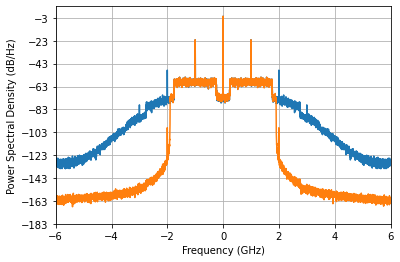

In [22]:
plt.psd(sigTxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');
plt.psd(sigRxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');
plt.xlabel('Frequency (GHz)')
plt.xlim(-6,6);

In [23]:
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
for ind, osnr in enumerate(OSNR):     
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
        power_DD_B2B[ind] = signal_power(sigTxo)
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # optical filter
        sigRxo = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_DD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]        

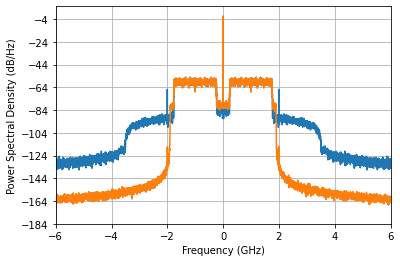

In [24]:
plt.psd(sigTxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');
plt.psd(sigRxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');
plt.xlabel('Frequency (GHz)')
plt.xlim(-6,6);

C:\Users\edson\AppData\Local\Temp\ipykernel_34852\3636036927.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(OSNR, np.log10(BER_CEDD_B2B), '-o', ms = 6, lw = 2, label = f'CE-DD Vb = {round(paramTx.Vb/paramTx.Vπ, 2)}$V\pi$')
C:\Users\edson\AppData\Local\Temp\ipykernel_34852\3636036927.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(OSNR, np.log10(BER_DD_B2B), '-o', ms = 6, lw = 2, label = f'DD Vb = {round(paramTx.Vb/paramTx.Vπ, 2)}$V\pi$')


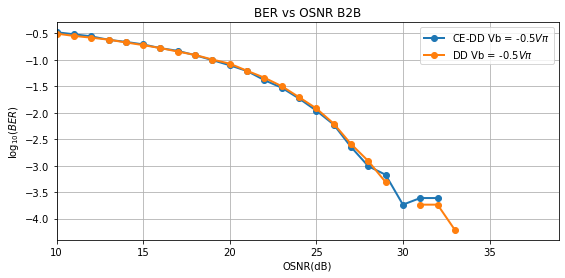

In [25]:
plt.figure(figsize = (9, 4))

plt.plot(OSNR, np.log10(BER_CEDD_B2B), '-o', ms = 6, lw = 2, label = f'CE-DD Vb = {round(paramTx.Vb/paramTx.Vπ, 2)}$V\pi$')
plt.plot(OSNR, np.log10(BER_DD_B2B), '-o', ms = 6, lw = 2, label = f'DD Vb = {round(paramTx.Vb/paramTx.Vπ, 2)}$V\pi$')

plt.title("BER vs OSNR B2B")
plt.xlabel(r"OSNR(dB)")
plt.ylabel(r"$\log_{10}(BER)$")
plt.legend(frameon = True)
plt.grid()
plt.xlim(min(OSNR), max(OSNR));


### Transmission performance (no dispersion, no nonlinear effects)

In [26]:
# Parâmetros da fibra
paramCh = parameters()
paramCh.Lspan   = 50          # Comprimento de um span de fibra [km]
paramCh.hz      = 1           # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [27]:
Pi_dBm  = np.array([2, 4, 8, 10])
Ltotal  = np.arange(100, 1500, 100)
osnrTx = 30

# CE-DDO-OFDM
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = "CE-DDO-OFDM"

BER_CEDD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(h_opt, sigTxo)
  
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
       
        # optical filter
        sigRxo = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CEDD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
# DDO-OFDM
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = "DDO-OFDM"

BER_DD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(h_opt, sigTxo)
          
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)

        # optical filter
        sigRxo = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_DD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\edson\AppData\Local\Temp\ipykernel_34852\4217082588.py:9: RuntimeWarning: divide by zero encountered in log10
  axs[1].plot(Ltotal, np.log10(BER_DD[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")


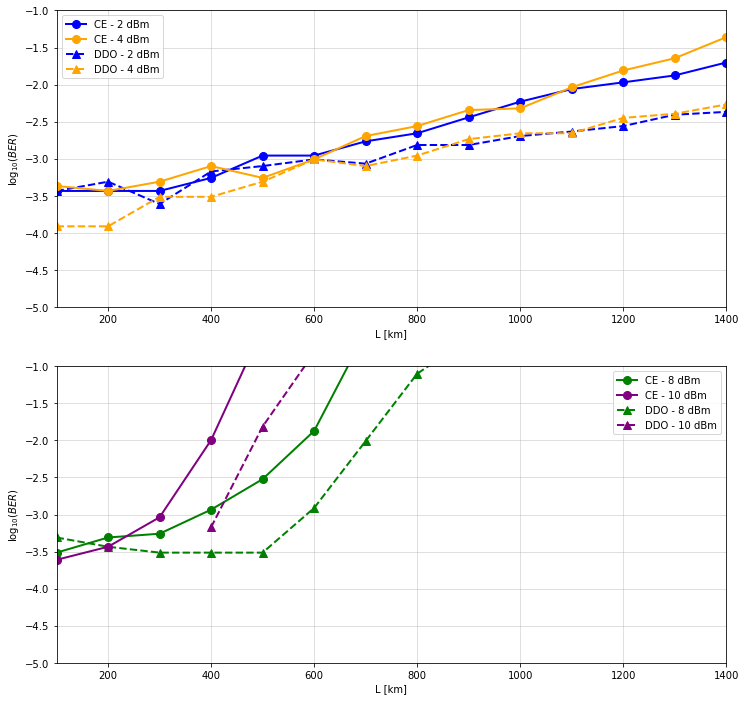

In [29]:
fig, axs = plt.subplots(2, 1, figsize = (12, 12))
color = ['blue', 'orange', 'green', 'purple']

for i in range(2):
    axs[0].plot(Ltotal, np.log10(BER_CEDD[i,:]), '-o', color = color[i], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i]} dBm")
    axs[0].plot(Ltotal, np.log10(BER_DD[i,:]), '--^', color = color[i], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i]} dBm")
    
    axs[1].plot(Ltotal, np.log10(BER_CEDD[i+2,:]), '-o', color = color[i+2], ms = 8, lw = 2, label = f"CE - {Pi_dBm[i+2]} dBm")
    axs[1].plot(Ltotal, np.log10(BER_DD[i+2,:]), '--^', color = color[i+2], ms = 8, lw = 2, label = f"DDO - {Pi_dBm[i+2]} dBm")
    
axs[0].set_xlabel(r"L [km]")
axs[0].set_ylabel(r"$\log_{10}(BER)$")
axs[0].set_ylim(-5, -1)
axs[0].set_xlim(min(Ltotal), max(Ltotal))
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.5)
axs[0].legend(frameon = True)

handles,labels = axs[0].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[0].legend(handles, labels, frameon = True)

axs[1].set_xlabel(r"L [km]")
axs[1].set_ylabel(r"$\log_{10}(BER)$")
axs[1].set_ylim(-5, -1)
axs[1].set_xlim(min(Ltotal), max(Ltotal))
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.5)
axs[1].legend(frameon = True)

handles,labels = axs[1].get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1], handles[3]]
labels = [labels[0], labels[2], labels[1], labels[3]]

axs[1].legend(handles, labels, frameon = True)

### BER vs Fiber input power

In [61]:
# Parâmetros da fibra
paramCh = parameters()
#paramCh.Ltotal  = 100
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 1           # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [62]:
Pi_dBm  = np.arange(-8, 12.5, 0.5) #np.array([-8, -4, -2, 0, 2, 4])
Ltotal  = np.arange(800, 900, 100)
osnrTx = 30

# CE-DDO-OFDM
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = "CE-DDO-OFDM"

BER_CEDD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
       
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(h_opt, sigTxo)
    sigRxo = sigTxo.copy()
    
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # optical filter
        sigRxo_ = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo_, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pnorm(pulse), t, paramRx)
        
        BER_CEDD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]
        
#         if j in [len(Ltotal)-5]:
#             print('L = '+str(Ltot)+'km Pin = '+str(Pi_dBm[i])+'dBm')
#             pconst(symbRx, pType='fancy');
#             plt.figure()           
#             plt.psd(sigRxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');

  0%|          | 0/46 [00:00<?, ?it/s]

In [63]:
# PAPR
print('PAPR sigTx_CE = %.2f dB' %(PAPR(paramTx.Nfft, sigTx_CE.real)))
print('PAPR sigTx = %.2f dB' %(PAPR(paramTx.Nfft, sigTx.real)))
print('PAPR sigTxo = %.2f dB' %(PAPR(paramTx.Nfft, sigTxo.real)))
print('PAPR sigRxo = %.2f dB' %(PAPR(paramTx.Nfft, sigRxo.real)))

PAPR sigTx_CE = 3.01 dB
PAPR sigTx = 12.65 dB
PAPR sigTxo = 1.83 dB
PAPR sigRxo = 13.12 dB


In [64]:
# DDO-OFDM
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = "DDO-OFDM"

BER_DD  = np.zeros((len(Pi_dBm), len(Ltotal)))

for i in tqdm(range(len(Pi_dBm))):
    paramTx.Pi_dBm = Pi_dBm[i]
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    sigRxo = sigTxo
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # optical filter
    sigTxo = firFilter(h_opt, sigTxo)
        
    for j, Ltot in enumerate(Ltotal):
        paramCh.Ltotal = Ltot
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # optical filter
        sigRxo_ = firFilter(h_opt, sigRxo)
        
        ipd = photodiode(sigRxo_, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pnorm(pulse), t, paramRx)
        
        BER_DD[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]
        
#         if j in [len(Ltotal)-5]:
#             print('L = '+str(Ltot)+'km Pin = '+str(Pi_dBm[i])+'dBm')
#             pconst(symbRx, pType='fancy');
#             plt.figure()           
#             plt.psd(sigRxo, Fs=paramTx.Fa/1e9, NFFT = 16*1024, sides='twosided');

  0%|          | 0/46 [00:00<?, ?it/s]

In [65]:
print('PAPR sigTx_DD = %.2f dB' %(PAPR(paramTx.Nfft, sigTx_DD.real)))
print('PAPR sigTx = %.2f dB' %(PAPR(paramTx.Nfft, sigTx.real)))
print('PAPR sigTxo = %.2f dB' %(PAPR(paramTx.Nfft, sigTxo.real)))
print('PAPR sigRxo = %.2f dB' %(PAPR(paramTx.Nfft, sigRxo.real)))

PAPR sigTx_DD = 15.80 dB
PAPR sigTx = 13.87 dB
PAPR sigTxo = 2.14 dB
PAPR sigRxo = 10.77 dB


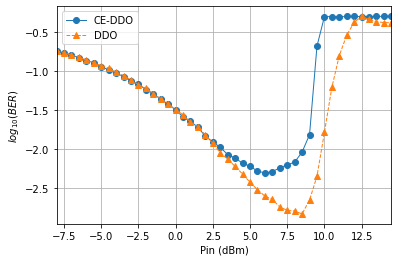

In [66]:
color = ['blue', 'orange', 'green', 'purple']
plt.plot(Pi_dBm, np.log10(BER_CEDD[:,0]), '-o', ms = 6, lw = 1, label = f"CE-DDO")
plt.plot(Pi_dBm, np.log10(BER_DD[:,0]), '--^', ms = 6, lw = 1, label = f"DDO")
plt.legend()
plt.grid()
plt.xlabel('Pin (dBm)')
plt.ylabel('$log_{10}(BER)$')
plt.xlim(min(Pi_dBm), max(Pi_dBm));